### Importation

In [2]:
import pandas as pd
import numpy as np
import re
from unicodedata import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle 
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn import metrics
from utilities import plot_confusion_matrix,plot_roc_auc,plot_classification_report
from utilities import grid_search_simple,graph_result,get_classes
from yellowbrick.classifier import ClassificationReport


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Fonction graphe (importé par utilities)

In [16]:
"""
def graph_result(fichier, n = 1500, variance = 0.05):
    result = pd.read_csv("hyperparameters/" + fichier)
    result_variance = result[(result['mean_train_score'] - result['mean_test_score']) < variance]
    
    plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
    
    plt.subplot(121)
    plt.scatter(result['rank_test_score'][result['rank_test_score'] < n],
                result['mean_test_score'][result['rank_test_score'] < n],color='red',
                marker = "+", label="Test Score")
    plt.scatter(result['rank_test_score'][result['rank_test_score'] < n],
                result['mean_train_score'][result['rank_test_score'] < n],color=-'blue',
                marker = "x", label="Train Score")
    
    plt.title("Test Score et Train Score \nen fonction du classement au Test Score",
              fontsize = 14, loc = 'center')
    plt.xlabel("Classement au Test Score",fontsize = 12)
    plt.ylabel("Score",fontsize = 12)
    plt.legend(loc = 3)
    
    plt.subplot(122)
    plt.scatter(result_variance['rank_test_score'][result_variance['rank_test_score'] < n],
                result_variance['mean_test_score'][result_variance['rank_test_score'] < n],color='red',
                marker = "+", label="Test Score")
    plt.scatter(result_variance['rank_test_score'][result_variance['rank_test_score'] < n],
                result_variance['mean_train_score'][result_variance['rank_test_score'] < n],color='blue',
                marker = "x", label="Train Score")
    
    plt.title("Test Score et Train Score \nen fonction du classement au Test Score",
              fontsize = 14, loc = 'center')
    plt.xlabel("Classement au Test Score",fontsize = 12)
    plt.ylabel("Score",fontsize = 12)
    plt.legend(loc = 3)
    plt.show()
"""


'\ndef graph_result(fichier, n = 1500, variance = 0.05):\n    result = pd.read_csv("hyperparameters/" + fichier)\n    result_variance = result[(result[\'mean_train_score\'] - result[\'mean_test_score\']) < variance]\n    \n    plt.figure(num=None, figsize=(14, 6), dpi=80, facecolor=\'w\', edgecolor=\'k\')\n    \n    plt.subplot(121)\n    plt.scatter(result[\'rank_test_score\'][result[\'rank_test_score\'] < n],\n                result[\'mean_test_score\'][result[\'rank_test_score\'] < n],color=\'red\',\n                marker = "+", label="Test Score")\n    plt.scatter(result[\'rank_test_score\'][result[\'rank_test_score\'] < n],\n                result[\'mean_train_score\'][result[\'rank_test_score\'] < n],color=-\'blue\',\n                marker = "x", label="Train Score")\n    \n    plt.title("Test Score et Train Score \nen fonction du classement au Test Score",\n              fontsize = 14, loc = \'center\')\n    plt.xlabel("Classement au Test Score",fontsize = 12)\n    plt.ylabel("

In [3]:
df = pd.read_csv("../../data/indeed.input.csv")
#list(df.columns)

In [4]:
y = df['salaire_moyen'][pd.notnull(df['salaire_moyen'])]
X = df.drop(columns = ['salaire_min','salaire_max','salaire_moyen','3 mois renouvelable_desc','3mois renouvelable_desc'])
X = X[pd.notnull(df['salaire_moyen'])]

**K-means pour la création des classes**

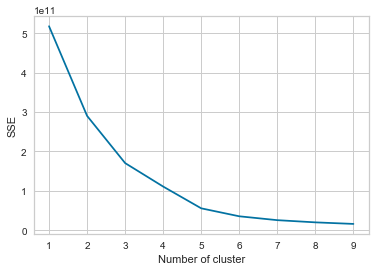

In [5]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter=1000).fit(y.values.reshape(-1, 1))
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [5]:
kmeans = KMeans(n_clusters=4,init = 'k-means++', max_iter=1000).fit(y.values.reshape(-1, 1))
y_class_orig = kmeans.labels_
correspondance = list(pd.DataFrame(kmeans.cluster_centers_,columns=['center']).sort_values('center').index)
y_dic = {correspondance[i]:i for i in range(len(kmeans.cluster_centers_))}
y_ord=[]
for j in y_class_orig:
    y_ord.append(y_dic[j])
y_class = np.array(y_ord)

In [6]:
for num in range(4):
    print((y_class_orig == num).sum(),':', (y_class == y_dic[num]).sum())

528 : 528
38 : 38
105 : 105
813 : 813


In [16]:
y[y_class == 0]

8        6600.0
64      15007.5
66       1320.0
78       1320.0
170      6960.0
237      6612.0
306      8700.0
330     15600.0
517     12397.5
689      7200.0
831      8400.0
879     25000.0
1211    15060.0
1259    25000.0
1344     6600.0
1422     7800.0
1460    12600.0
1469     8400.0
1470    10800.0
1580    25000.0
1683    21600.0
1712    16800.0
1714     1320.0
1858    25200.0
1861    14400.0
1955    12000.0
2022     7200.0
2108    12600.0
2146    12000.0
2155    12600.0
         ...   
5990    24000.0
6028     1000.0
6075    15600.0
6196     6000.0
6255     6648.0
6304    10048.5
6332     8400.0
6374    12000.0
6394    11092.5
6426     6000.0
6440    25320.0
6630    24000.0
6667    12600.0
6722     6600.0
6767    12000.0
6786     6816.0
6808     9600.0
6826    24000.0
6874    24500.0
6920     7200.0
6928    25200.0
7099    15600.0
7106    24500.0
7362    22200.0
7466    12000.0
7486     7200.0
7507    21600.0
7566    22000.0
7612    12000.0
8007    15600.0
Name: salaire_moyen, Len

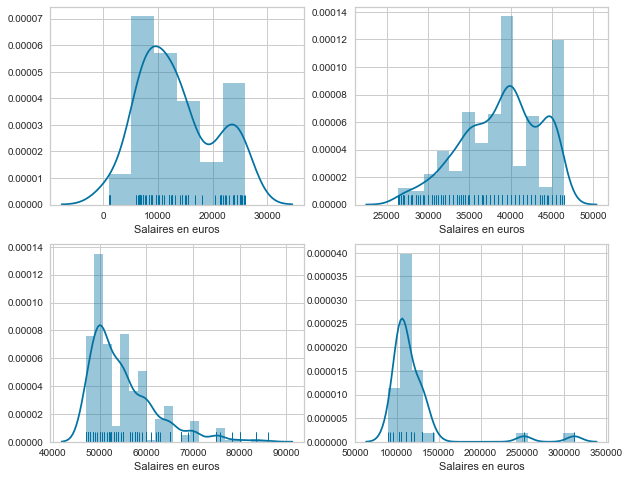

In [17]:
import seaborn as sns
f, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.distplot(a = list(y[y_class == 0]),
             rug = True, axlabel='Salaires en euros',ax=axes[0,0])
sns.distplot(a = list(y[y_class == 1]),
             rug = True, axlabel='Salaires en euros',ax=axes[0,1])
sns.distplot(a = list(y[y_class == 2]),
             rug = True, axlabel='Salaires en euros',ax=axes[1,0])
sns.distplot(a = list(y[y_class == 3]),
             rug = True, axlabel='Salaires en euros',ax=axes[1,1])


**Création des classes pour le graphique**

In [8]:
centroid = kmeans.cluster_centers_
centroid.sort(axis = 0)
centre = list(centroid.reshape(1,-1)[0])
classe = [(centre[i]+centre[i+1])/2 for i in range(len(centre) - 1)]
classe_labels = []
for index, item in enumerate(classe):
    b = 0
    e = int(classe[index]/1000)
    if index > 0:
        b = int(classe[index-1]/1000)
    classe_labels.append("[{0}K - {1}K]".format(b,e))
classe_labels.append("[{0}K - {1}]".format(int(classe[len(classe)-1]/1000),"+"))
dic_classe_labels = {i:classe_labels[i] for i in range(len(classe_labels))}

**Séparation de Train et Test**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.25, random_state=0)
features = list((X_train.sum(axis = 0) != 0))
X_train = X_train.iloc[:,features]
X_test = X_test.iloc[:,features]

###  Fonction GridSearch Reg log, SVM, Kernel SVM (importé par utilities)

In [24]:
"""
def grid_search_simple(classificateur,file_name, X, y):
    modeles = {"logreg":[LogisticRegression(),[
                {'penalty': ['l2'],'C':[0.1,0.6,1,2,5,10],
                  'multi_class':['ovr', 'multinomial'],'class_weight':['balanced', None],
                  'solver':['lbfgs','sag','newton-cg'],'max_iter':[1000]
                },
                {'penalty': ['l1','l2'],'C':[0.1,0.6,1,2,5,10],
                  'multi_class':['ovr'],'class_weight':['balanced', None],
                  'solver':['liblinear'],'max_iter':[1000]
                },]],
              "SVM":[SVC(),[
                {'C': [0.1,0.6,1,2,5,10],'class_weight':['balanced', None],
                 'gamma': ['scale','auto'], 'kernel': ['linear'],
                 'decision_function_shape': ['ovo', 'ovr']
                },
                {'C': [0.1,0.6,1,2,5,10], 'class_weight':['balanced', None],
                 'gamma': ['scale','auto'], 'kernel': ['rbf'],
                 'decision_function_shape': ['ovo', 'ovr']
                },
                {'C': [0.1,0.6,1,2,5,10], 'class_weight':['balanced', None],
                 'gamma': ['scale','auto'], 'kernel': ['poly'], 'degree': [2,3,4,5,6,7],
                 'decision_function_shape': ['ovo', 'ovr']
                },
                {'C': [0.1,0.6,1,2,5,10],'class_weight':['balanced', None],
                 'gamma': ['scale','auto'], 'kernel': ['sigmoid'],
                 'decision_function_shape': ['ovo', 'ovr']
                }]],
              "RanFor":[RandomForestClassifier(),{
                   'n_estimators': [50,100,150,200],
                   "criterion": ["gini", "entropy"],
                   "max_depth": [3, 5, None],
                   "min_samples_split": [2, 3, 5],
                   "max_features": ["sqrt", "log2", None],
                   "bootstrap": [True, False],
                   "class_weight": ["balanced", "balanced_subsample", None]
                   }],
              "ExtTre":[ExtraTreesClassifier(),{
                   'n_estimators': [50,100,150,200],
                   "criterion": ["gini", "entropy"],
                   "max_depth": [3, 5, None],
                   "min_samples_split": [2, 3, 5],
                   "max_features": ["sqrt", "log2", None],
                   "bootstrap": [True, False],
                   "class_weight": ["balanced", "balanced_subsample", None]
                  }],
              "graboo":[GradientBoostingClassifier(),{"loss":["deviance"],
                   "learning_rate": [0.1, 0.3, 0.5],
                   "min_samples_split": [0.1, 0.5, 2],
                   "min_samples_leaf": [0.1, 0.5, 1],
                   "max_depth":[3,5,8],
                   "max_features":["log2","sqrt",None],
                   "criterion": ["friedman_mse"],
                   "subsample":[0.5, 0.8, 1.0],
                   "n_estimators":[100,150,200]
                  }],
              "xgboost":[xgb.XGBClassifier(),{'nthread':[4], #when use hyperthread, xgboost may become slower
                  'objective':['binary:logistic'],
                  'learning_rate': [0.05], #so called `eta` value
                  'max_depth': [6],
                  'min_child_weight': [11],
                  'silent': [1],
                  'subsample': [0.8],
                  'colsample_bytree': [0.7],
                  'n_estimators': [5], #number of trees, change it to 1000 for better results
                  'missing':[-999],
                  'seed': [1337]}]}
    
    
    estimat = modeles[classificateur][0]
    parameters = modeles[classificateur][1]
    clf = GridSearchCV(estimat, param_grid = parameters, return_train_score=True, cv = 5, n_jobs=-1)
    clf.fit(X, y)
    result = pd.DataFrame.from_dict(clf.cv_results_)
    best = [clf.best_estimator_, clf.best_score_, clf.best_params_, clf.scorer_]
    
    hyperparameters_file = "hyperparameters/" + file_name + ".csv"
    weights_file = "weights/" + file_name + ".sav"
    
    result.to_csv(hyperparameters_file, index = False)
    pickle.dump(clf.best_estimator_, open(weights_file, 'wb'))
    
    print(clf.best_estimator_)
    return clf.best_estimator_
"""

'\ndef grid_search_simple(classificateur,file_name, X, y):\n    modeles = {"logreg":[LogisticRegression(),[\n                {\'penalty\': [\'l2\'],\'C\':[0.1,0.6,1,2,5,10],\n                  \'multi_class\':[\'ovr\', \'multinomial\'],\'class_weight\':[\'balanced\', None],\n                  \'solver\':[\'lbfgs\',\'sag\',\'newton-cg\'],\'max_iter\':[1000]\n                },\n                {\'penalty\': [\'l1\',\'l2\'],\'C\':[0.1,0.6,1,2,5,10],\n                  \'multi_class\':[\'ovr\'],\'class_weight\':[\'balanced\', None],\n                  \'solver\':[\'liblinear\'],\'max_iter\':[1000]\n                },]],\n              "SVM":[SVC(),[\n                {\'C\': [0.1,0.6,1,2,5,10],\'class_weight\':[\'balanced\', None],\n                 \'gamma\': [\'scale\',\'auto\'], \'kernel\': [\'linear\'],\n                 \'decision_function_shape\': [\'ovo\', \'ovr\']\n                },\n                {\'C\': [0.1,0.6,1,2,5,10], \'class_weight\':[\'balanced\', None],\n              

## Regression logistique

In [19]:
%%time
logreg_estimator = grid_search_simple("logreg","logregfinal", X_train, y_train)

LogisticRegression(C=0.6, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
Wall time: 2min 24s


C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


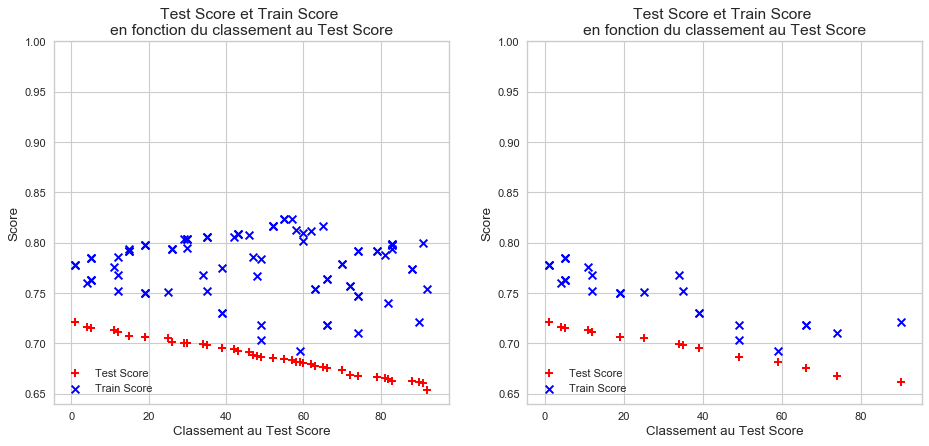

In [20]:
graph_result("logregfinal.csv")

## SVM

In [21]:
%%time
svm_estimator = grid_search_simple("SVM","SVMfinal", X_train, y_train)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)
Wall time: 5min 6s


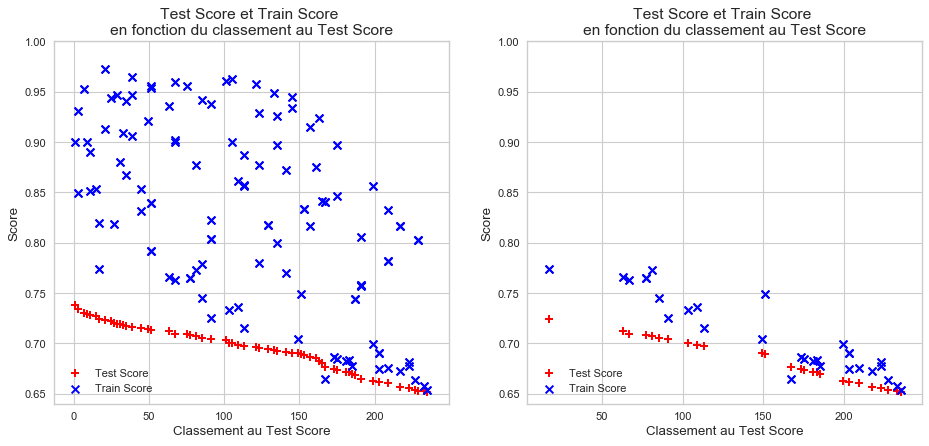

In [22]:
graph_result("SVMfinal.csv")

## Random forest

In [23]:
%%time
RanFor_estimator = grid_search_simple("RanFor","RanForfinal", X_train, y_train)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=None, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
Wall time: 18min 53s


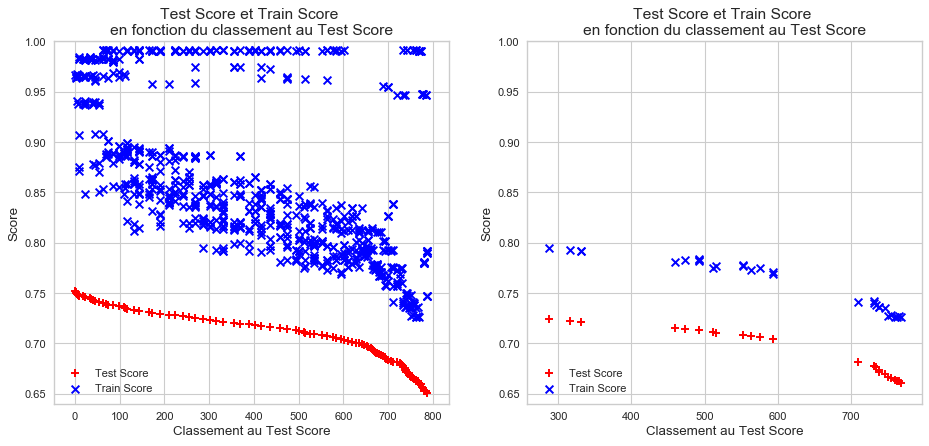

In [24]:
graph_result("RanForfinal.csv")

In [18]:
analyse = pd.read_csv("hyperparameters/RanFor3.csv")
bob = analyse[(analyse['mean_train_score'] - analyse['mean_test_score']) < 0.1 * analyse['mean_test_score']].sort_values('rank_test_score')
bob[['param_class_weight','rank_test_score','param_min_samples_split','param_max_depth','mean_test_score']]

,param_class_weight,rank_test_score,param_min_samples_split,param_max_depth,mean_test_score
302,NaN,239,2,8.0,0.753752
300,NaN,239,2,8.0,0.753752
301,NaN,243,2,8.0,0.752387
303,NaN,246,5,8.0,0.751023
304,NaN,257,5,8.0,0.748977
305,NaN,275,5,8.0,0.746248
372,NaN,335,2,8.0,0.739427
375,NaN,346,5,8.0,0.738745
373,NaN,353,2,8.0,0.738063
225,balanced_subsample,370,5,8.0,0.736016


## ExtraTrees

In [25]:
%%time
ExtTre_estimator = grid_search_simple("ExtTre","ExtTrefinal", X_train, y_train)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
Wall time: 20min 20s


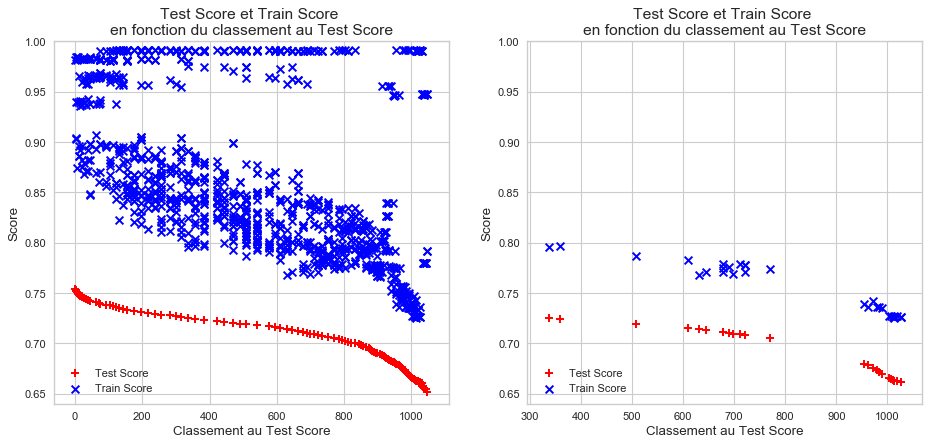

In [26]:
graph_result("ExtTrefinal.csv")

## GradientBoost

In [9]:
%%time
graboo_estimator = grid_search_simple("graboo","graboofinal", X_train, y_train)

C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=0,
              subsample=0.8, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Wall time: 1h 9min 26s


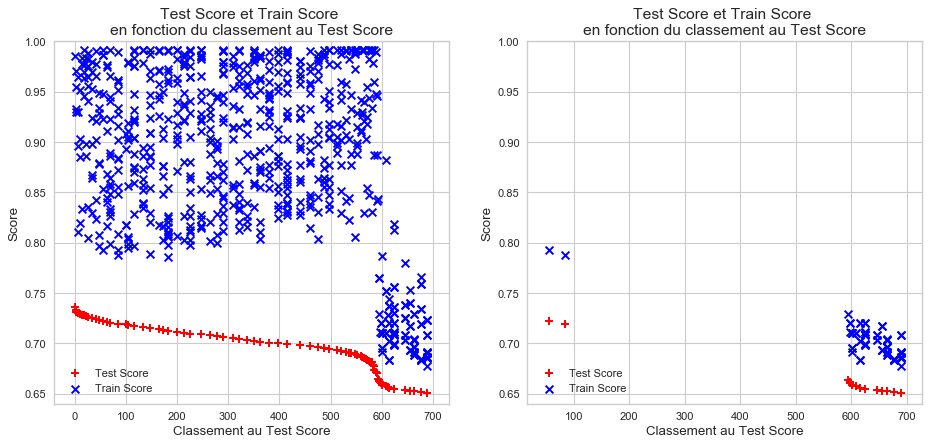

In [10]:
graph_result("graboofinal.csv")

## AdaBoost

In [ ]:
model = AdaBoostClassifier()
hyperparameters1 = {'n_estimators': [100,150,200],
                   "criterion": ["entropy",'gini'],
                   "max_depth": [2, 5, 8, 10],
                   "max_features": ["auto", "log2", None],
                   "random_state": [0]
                  }
base_est_ran = [DecisionTreeClassifier.set_params(**ele) for ele in ParameterGrid(hyperparameters1)]
hyperparameters = {'base_estimator': base_est_ran,                   
                   'n_estimators': [100,150,200],
                   'learning_rate' : [0.2,0.3,0.4],
                   'algorithm' : ['SAMME.R']
                  }
clf_Ada_ran = GridSearchCV(model, param_grid = hyperparameters, return_train_score=True,
                           error_score='raise',n_jobs= -1)
clf_Ada_ran.fit(X_train, y_train)
result_Ada_ran = pd.DataFrame.from_dict(clf_Ada_ran.cv_results_)
#Predict values based on new parameters
y_pred_Ada_ran = clf_Ada_ran.predict(X_test)
result_Ada_ran.to_csv("result_Ada_ran.csv", index = False)

## xgboost

In [25]:
%%time
xgboost_estimator = grid_search_simple("xgboost","xgboostfinal", X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Wall time: 9min 6s


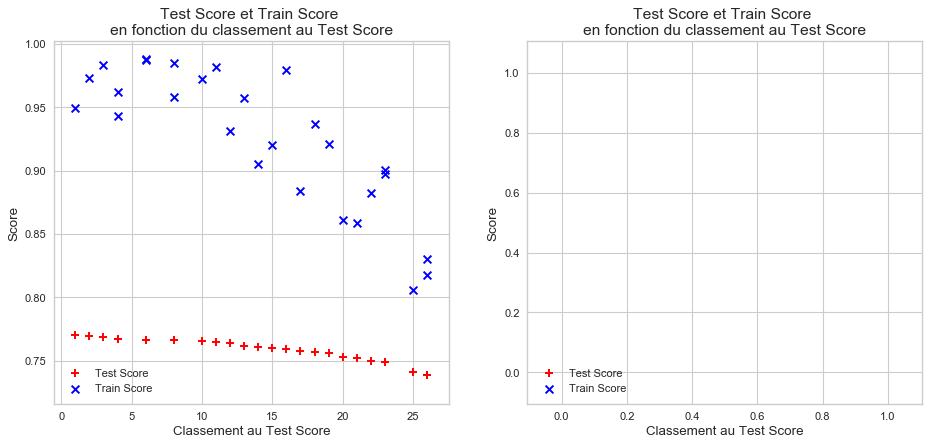

In [26]:
graph_result("xgboostfinal.csv")

In [5]:
result = pd.read_csv("hyperparameters/xgboost.csv")
list(result.sort_values(by = 'rank_test_score')['params'])

["{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 150, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 100, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 100, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 150, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 150, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.5, 'max_depth': 8, 'n_estimators': 200, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 200, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 150, 'objective': 'multi:softmax'}",
 "{'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 150

## Metrics du meilleur modèle : SVM

In [11]:
svc_best_estimator = SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
                          decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
                          max_iter=-1, probability=False, random_state=None, shrinking=True,
                          tol=0.001, verbose=False)

**Rapport de classification**

['[0K - 26K]', '[26K - 47K]', '[47K - 85K]', '[85K - +]']


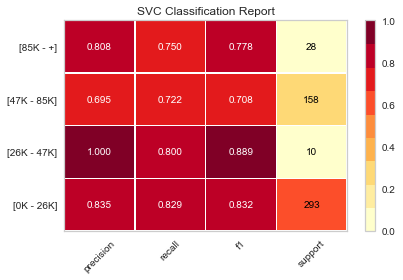

In [12]:
print(classe_labels)
plot_classification_report(svc_best_estimator, X_train, y_train,X_test, y_test, classe_labels) 

**Matrice de confusion**

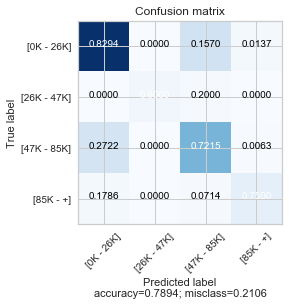

In [17]:
y_pred_SVM = svc_best_estimator.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred_SVM,labels=[0,1,2,3])
#print(cm)
plot_confusion_matrix(cm, classe_labels)

**ROC et AUC**

['[0K - 26K]', '[26K - 46K]', '[46K - 85K]', '[85K - +]']


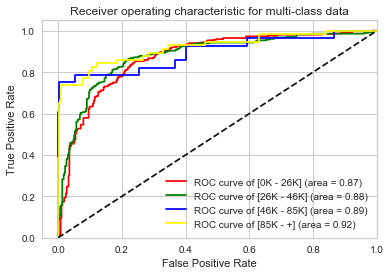

In [18]:
plot_roc_auc(svc_best_estimator,X_train, y_train, classe_labels, ["red", "green", "blue", "yellow"])

In [ ]:
RandomForestClassifier(random_state=)